# Preprocessing

* the value of our product

Our product helps potential kickstarter creators assess whether their project will get funding.
It supports them in finding out if it's worth investing the time and money to launch their project and which criteria to consider in order to make it successful.

* what will you predict, based on what, and evaluation metric used

We will predict whether a project will be successfully funded on Kickstarter.
Our model will be based on features like the funding goal, the currency the goal is in and the category of the project.
We will use the F1-score as the evaluation metric in order to get a good balance between precision and recall.
Both false positives (predicting that a project will be funded and the creator investing time and money to fail in the end) and false negatives (predicting that a project will be unsuccessful and preventing the creators from realizing their idea) are equally undesirable in this context.

* short description of baseline, and the score (based on eval metric)

Our baseline model is a dummy classifier predicting the most frequent class (in this case success).
It reaches an F1-score (our metric of interest) of 76% and an accuracy of 61%.

---

First step: Run the combin_csv.py script on a data folder containing ONLY the kickstarter000 to kickstarter055 csv-files! This gives you the dataset to import for this notebook.

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix

In [29]:
# load the combined dataset
df = pd.read_csv("data/combined_csv.csv")

# check the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             209222 non-null  int64  
 1   blurb                     209214 non-null  object 
 2   category                  209222 non-null  object 
 3   converted_pledged_amount  209222 non-null  int64  
 4   country                   209222 non-null  object 
 5   created_at                209222 non-null  int64  
 6   creator                   209222 non-null  object 
 7   currency                  209222 non-null  object 
 8   currency_symbol           209222 non-null  object 
 9   currency_trailing_code    209222 non-null  bool   
 10  current_currency          209222 non-null  object 
 11  deadline                  209222 non-null  int64  
 12  disable_communication     209222 non-null  bool   
 13  friends                   300 non-null     o

## list of features we keep

 -  blurb                     short description 
 -  category                  Kickstarter categories  
 -  country                   country 
 -  deadline                  deadline date/time?
 -  fx_rate                   currency conversion rate 
 -  goal                      fixed amount required for funding (convert with fx_rate)
 -  launched_at               launch date/time?  
 -  location                  location
 -  name                      project name 
 -  state                     !!!!!target!!!!! 

 <br>

features to create:
- goal_usd                    goal*fx_rate
- name_len                    number of characters in name
- blurb_len                   number of characters in blurb
- time_online                 deadline - launched at
- launch_weekday              day of the week of the launch
- launch_time                 time of day of the launch

## stakeholder

* who? - people/creators who are considering launching a project on Kickstarter
* why? - to find out if it's worth investing the time/money in creating materials/launching a project and which criteria to consider in order to make it successful
* metric? - f_beta (probably imbalanced data)
* model: classifier (binary)

In [30]:
# keep only columns we will be using

df = df[['blurb', 'category', 'country', 'deadline',
        'fx_rate', 'goal', 'launched_at', 'location',
       'name', 'state']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   blurb        209214 non-null  object 
 1   category     209222 non-null  object 
 2   country      209222 non-null  object 
 3   deadline     209222 non-null  int64  
 4   fx_rate      209222 non-null  float64
 5   goal         209222 non-null  float64
 6   launched_at  209222 non-null  int64  
 7   location     208996 non-null  object 
 8   name         209222 non-null  object 
 9   state        209222 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 16.0+ MB


## Create the new features

### Convert timestamps & add time delta features

In [31]:
launched = []
deadline = []

In [32]:
# launched_at
for label, content in df['launched_at'].iteritems():
    launched.append(datetime.datetime.fromtimestamp(content))

In [33]:
# deadline
for label, content in df['deadline'].iteritems():
    deadline.append(datetime.datetime.fromtimestamp(content))

In [34]:
for i in range(len(df)):
    df['launched_at'].iloc[[i]] = launched[i]

In [35]:
for i in range(len(df)):
    df['deadline'].iloc[[i]] = deadline[i]

In [36]:
df['delta_dead_laun'] = (df['deadline'] - df['launched_at']).astype('timedelta64[h]')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   blurb            209214 non-null  object 
 1   category         209222 non-null  object 
 2   country          209222 non-null  object 
 3   deadline         209222 non-null  object 
 4   fx_rate          209222 non-null  float64
 5   goal             209222 non-null  float64
 6   launched_at      209222 non-null  object 
 7   location         208996 non-null  object 
 8   name             209222 non-null  object 
 9   state            209222 non-null  object 
 10  delta_dead_laun  209222 non-null  float64
dtypes: float64(3), object(8)
memory usage: 17.6+ MB


### change categories to main categories

In [38]:
# subset category column 
cat_df = df.loc[:,['category']]

# split category column
cat_df[['id','name','slug','position','parent_id','color','urls']] = df['category'].str.split(',',expand=True)

In [39]:
# subset column 'slug' as dataframe
cat = cat_df.loc[:,['slug']]

cat['slug'] = cat['slug'].str.replace(r'"slug":', '')
cat['slug'] = cat['slug'].str.replace(r'"', '')
cat['slug']

# rename 'slug' to 'category'
cat.rename(columns={'slug': 'category'}, inplace=True)

# drop column 'category' from original dataframe
df.drop('category', axis=1, inplace=True)

# add new column 'category' to original dataframe
df['category'] = cat

In [40]:
cats = df['category']

In [41]:
cats = cats.str.strip('"slug')

In [42]:
cats = cats.str.strip(':"')

In [43]:
cats

0               fashion/footwear
1              ames/playing card
2                     music/rock
3              ames/playing card
4          publishing/nonfiction
                   ...          
209217        ames/tabletop game
209218    music/electronic music
209219       technology/hardware
209220      film & video/festiva
209221                journalism
Name: category, Length: 209222, dtype: object

In [44]:
cats = cats.str.split("/").str[0]

In [45]:
cats.unique()

array(['fashion', 'ames', 'music', 'publishing', 'theater', 'food', 'art',
       'photography', 'technology', 'dance', 'design', 'film & video',
       'crafts', 'comics', 'comic', 'craft', 'journalism', 'publishin',
       'ame'], dtype=object)

In [46]:
# add new categories to dataframe

df['category'] = cats
df['category'].unique()

array(['fashion', 'ames', 'music', 'publishing', 'theater', 'food', 'art',
       'photography', 'technology', 'dance', 'design', 'film & video',
       'crafts', 'comics', 'comic', 'craft', 'journalism', 'publishin',
       'ame'], dtype=object)

### Include weekday and hour of launch

In [47]:
launched_day = pd.to_datetime(df['launched_at']).dt.day_of_week

In [48]:
launched_hour = pd.to_datetime(df['launched_at']).dt.hour

In [49]:
df['launch_day'] = launched_day
df['launch_hour'] = launched_hour
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   blurb            209214 non-null  object 
 1   country          209222 non-null  object 
 2   deadline         209222 non-null  object 
 3   fx_rate          209222 non-null  float64
 4   goal             209222 non-null  float64
 5   launched_at      209222 non-null  object 
 6   location         208996 non-null  object 
 7   name             209222 non-null  object 
 8   state            209222 non-null  object 
 9   delta_dead_laun  209222 non-null  float64
 10  category         209222 non-null  object 
 11  launch_day       209222 non-null  int64  
 12  launch_hour      209222 non-null  int64  
dtypes: float64(3), int64(2), object(8)
memory usage: 20.8+ MB


,blurb,country,deadline,fx_rate,goal,launched_at,location,name,state,delta_dead_laun,category,launch_day,launch_hour
0,Babalus Shoes,US,2019-03-14 06:02:55,1.000000,28000.0,2019-01-23 07:02:55,"{""id"":2462429,""name"":""Novato"",""slug"":""novato-c...",Babalus Children's Shoes,live,1199.0,fashion,2,7
1,A colorful Dia de los Muertos themed oracle de...,US,2017-09-09 19:00:59,1.000000,1000.0,2017-08-10 19:00:59,"{""id"":2400549,""name"":""Euless"",""slug"":""euless-t...",The Ofrenda Oracle Deck,successful,720.0,ames,3,19
2,"Electra's long awaited, eclectic Debut Pop/Roc...",US,2013-06-12 07:03:15,1.000000,15000.0,2013-05-13 07:03:15,"{""id"":2423474,""name"":""Hollywood"",""slug"":""holly...","Record Electra's Debut Album (Pop, Rock, Class...",successful,720.0,music,0,7
3,The Mist of Tribunal is a turn-based card game...,GB,2017-03-13 18:22:56,1.308394,10000.0,2017-01-12 19:22:56,"{""id"":475457,""name"":""Kaunas"",""slug"":""kaunas-ka...",The Mist of Tribunal - A Card Game,failed,1439.0,ames,3,19
4,"Livng with a brain impairment, what its like t...",US,2013-01-09 21:32:07,1.000000,2800.0,2012-12-10 21:32:07,"{""id"":2507703,""name"":""Traverse City"",""slug"":""t...",Help change the face of Brain Impairment,successful,720.0,publishing,0,21


### blurb length and name length

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   blurb            209214 non-null  object 
 1   country          209222 non-null  object 
 2   deadline         209222 non-null  object 
 3   fx_rate          209222 non-null  float64
 4   goal             209222 non-null  float64
 5   launched_at      209222 non-null  object 
 6   location         208996 non-null  object 
 7   name             209222 non-null  object 
 8   state            209222 non-null  object 
 9   delta_dead_laun  209222 non-null  float64
 10  category         209222 non-null  object 
 11  launch_day       209222 non-null  int64  
 12  launch_hour      209222 non-null  int64  
dtypes: float64(3), int64(2), object(8)
memory usage: 20.8+ MB


In [51]:
# drop missing values for blurb
df = df[df['blurb'].notnull()]

In [52]:
# calculate length of name
name_len = []
for label, content in df['name'].iteritems():
    name_len.append(len(content))

df['name_len'] = name_len


# calculate length of blurb
blurb_len = []
for label, content in df['blurb'].iteritems():
    blurb_len.append(len(content))

df['blurb_len'] = blurb_len

In [55]:
df.head()

,blurb,country,deadline,fx_rate,goal,launched_at,location,name,state,delta_dead_laun,category,launch_day,launch_hour,name_len,blurb_len
1,A colorful Dia de los Muertos themed oracle de...,US,2017-09-09 19:00:59,1.000000,1000.0,2017-08-10 19:00:59,"{""id"":2400549,""name"":""Euless"",""slug"":""euless-t...",The Ofrenda Oracle Deck,1,720.0,ames,3,19,23,125
2,"Electra's long awaited, eclectic Debut Pop/Roc...",US,2013-06-12 07:03:15,1.000000,15000.0,2013-05-13 07:03:15,"{""id"":2423474,""name"":""Hollywood"",""slug"":""holly...","Record Electra's Debut Album (Pop, Rock, Class...",1,720.0,music,0,7,51,108
3,The Mist of Tribunal is a turn-based card game...,GB,2017-03-13 18:22:56,1.308394,10000.0,2017-01-12 19:22:56,"{""id"":475457,""name"":""Kaunas"",""slug"":""kaunas-ka...",The Mist of Tribunal - A Card Game,0,1439.0,ames,3,19,34,133
4,"Livng with a brain impairment, what its like t...",US,2013-01-09 21:32:07,1.000000,2800.0,2012-12-10 21:32:07,"{""id"":2507703,""name"":""Traverse City"",""slug"":""t...",Help change the face of Brain Impairment,1,720.0,publishing,0,21,40,121
5,Annapolis Chamber Players is a non-for profit ...,US,2015-05-02 04:25:46,1.000000,3500.0,2015-04-02 04:25:46,"{""id"":2354877,""name"":""Annapolis"",""slug"":""annap...",Annapolis Chamber Music Project,1,720.0,music,3,4,31,134


In [56]:
df['goal_usd'] = df['goal'] * df['fx_rate']

In [57]:
df = df.query('goal_usd >= 100 or goal_usd <= 1000000')

In [58]:
df.head()

,blurb,country,deadline,fx_rate,goal,launched_at,location,name,state,delta_dead_laun,category,launch_day,launch_hour,name_len,blurb_len,goal_usd
1,A colorful Dia de los Muertos themed oracle de...,US,2017-09-09 19:00:59,1.000000,1000.0,2017-08-10 19:00:59,"{""id"":2400549,""name"":""Euless"",""slug"":""euless-t...",The Ofrenda Oracle Deck,1,720.0,ames,3,19,23,125,1000.0000
2,"Electra's long awaited, eclectic Debut Pop/Roc...",US,2013-06-12 07:03:15,1.000000,15000.0,2013-05-13 07:03:15,"{""id"":2423474,""name"":""Hollywood"",""slug"":""holly...","Record Electra's Debut Album (Pop, Rock, Class...",1,720.0,music,0,7,51,108,15000.0000
3,The Mist of Tribunal is a turn-based card game...,GB,2017-03-13 18:22:56,1.308394,10000.0,2017-01-12 19:22:56,"{""id"":475457,""name"":""Kaunas"",""slug"":""kaunas-ka...",The Mist of Tribunal - A Card Game,0,1439.0,ames,3,19,34,133,13083.9361
4,"Livng with a brain impairment, what its like t...",US,2013-01-09 21:32:07,1.000000,2800.0,2012-12-10 21:32:07,"{""id"":2507703,""name"":""Traverse City"",""slug"":""t...",Help change the face of Brain Impairment,1,720.0,publishing,0,21,40,121,2800.0000
5,Annapolis Chamber Players is a non-for profit ...,US,2015-05-02 04:25:46,1.000000,3500.0,2015-04-02 04:25:46,"{""id"":2354877,""name"":""Annapolis"",""slug"":""annap...",Annapolis Chamber Music Project,1,720.0,music,3,4,31,134,3500.0000


## Drop every feature we don't need

In [59]:
df.drop(['blurb', 'deadline', 'fx_rate', 'goal', 'launched_at', 'location', 'name'], axis=1, inplace=True)

In [60]:
df.head()

,country,state,delta_dead_laun,category,launch_day,launch_hour,name_len,blurb_len,goal_usd
1,US,1,720.0,ames,3,19,23,125,1000.0000
2,US,1,720.0,music,0,7,51,108,15000.0000
3,GB,0,1439.0,ames,3,19,34,133,13083.9361
4,US,1,720.0,publishing,0,21,40,121,2800.0000
5,US,1,720.0,music,3,4,31,134,3500.0000


In [70]:
cat_backup = df[['category']]

In [71]:
type(cat_backup)

pandas.core.frame.DataFrame

In [72]:
cat_backup['category'].unique()

array(['ames', 'music', 'publishing', 'theater', 'fashion', 'food',
       'photography', 'art', 'technology', 'dance', 'design',
       'film & video', 'crafts', 'comics', 'comic', 'craft', 'journalism',
       'publishin', 'ame'], dtype=object)

In [73]:
cat_backup.replace(to_replace={'ames': 'games', 'ame': 'games', 'comic': 'comics', 'publishin': 'publishing'}, inplace=True)

In [74]:
cat_backup['category'].unique()

array(['games', 'music', 'publishing', 'theater', 'fashion', 'food',
       'photography', 'art', 'technology', 'dance', 'design',
       'film & video', 'crafts', 'comics', 'craft', 'journalism'],
      dtype=object)

In [75]:
df['category'] = cat_backup['category']

In [76]:
df.head()

,country,state,delta_dead_laun,category,launch_day,launch_hour,name_len,blurb_len,goal_usd
1,US,1,720.0,games,3,19,23,125,1000.0000
2,US,1,720.0,music,0,7,51,108,15000.0000
3,GB,0,1439.0,games,3,19,34,133,13083.9361
4,US,1,720.0,publishing,0,21,40,121,2800.0000
5,US,1,720.0,music,3,4,31,134,3500.0000


### Include only projects that were successful or failed

In [53]:
# convert 'state' to numerical
# successful: 1
# failed: 0
# drop: live, suspended, canceled

df = df.query('state != "live"')
df = df.query('state != "suspended"')
df = df.query('state != "canceled"')
print(df['state'].unique()) # check that 'state' only contains failed and successful

df['state'].replace({'failed':0, 'successful':1}, inplace=True)
print(df['state'].unique()) # check that 'state' only contains 1 and 0

['successful' 'failed']
[1 0]


<AxesSubplot:xlabel='state', ylabel='count'>

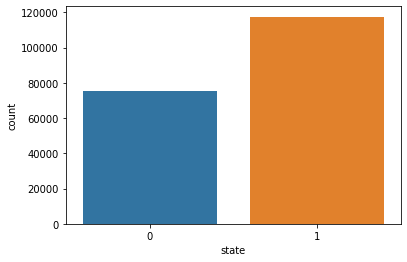

In [54]:
# plot frequency of success and failure

sns.countplot(x='state', data=df)

In [77]:
## save dataframe
df.to_csv( "data/df_preprocessed.csv", index=False, encoding='utf-8-sig')

In [78]:
# log transform goal_usd
df['goal_usd_log'] = np.log(df['goal_usd'])

In [80]:
df.drop('goal_usd', axis=1, inplace=True)

In [81]:
df.head()

,country,state,delta_dead_laun,category,launch_day,launch_hour,name_len,blurb_len,goal_usd_log
1,US,1,720.0,games,3,19,23,125,6.907755
2,US,1,720.0,music,0,7,51,108,9.615805
3,GB,0,1439.0,games,3,19,34,133,9.479141
4,US,1,720.0,publishing,0,21,40,121,7.937375
5,US,1,720.0,music,3,4,31,134,8.160518


In [82]:
## save dataframe
df.to_csv( "data/df_preprocessed_log.csv", index=False, encoding='utf-8-sig')

In [83]:
# get dummies
country_cat = pd.get_dummies(df['country'], drop_first=True)
cat_cat = pd.get_dummies(df['category'], drop_first=True)

In [84]:
df = pd.concat([df, country_cat, cat_cat], axis=1)

In [85]:
df.drop(['country', 'category'], axis=1, inplace=True)

In [86]:
df.head()

,state,delta_dead_laun,launch_day,launch_hour,name_len,blurb_len,goal_usd_log,AU,BE,CA,...,fashion,film & video,food,games,journalism,music,photography,publishing,technology,theater
1,1,720.0,3,19,23,125,6.907755,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,720.0,0,7,51,108,9.615805,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1439.0,3,19,34,133,9.479141,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,720.0,0,21,40,121,7.937375,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,1,720.0,3,4,31,134,8.160518,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [87]:
## save dataframe
df.to_csv( "data/df_preprocessed_log_dummies.csv", index=False, encoding='utf-8-sig')

In [ ]:
from sklearn.dummy import DummyClassifier
X = df.drop('state', axis=1)
y = df['state']

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)

DummyClassifier(strategy='most_frequent')

In [ ]:
y_pred_dummy = dummy_clf.predict(X)

In [ ]:
dummy_clf.score(X, y)

0.6096883693891957

In [ ]:
print(classification_report(y, y_pred_dummy))

/Users/zoe/neuefische/kickstarter-ml/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zoe/neuefische/kickstarter-ml/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      failed       0.00      0.00      0.00     75199
  successful       0.61      1.00      0.76    117465

    accuracy                           0.61    192664
   macro avg       0.30      0.50      0.38    192664
weighted avg       0.37      0.61      0.46    192664



/Users/zoe/neuefische/kickstarter-ml/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cfm_dummy = confusion_matrix(y, y_pred_dummy)
cfm_dummy = cfm_dummy.astype('float') / cfm_dummy.sum(axis=1)[:, np.newaxis] # normalize the data

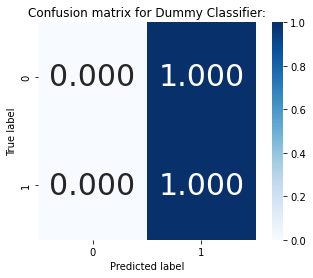

In [ ]:
# view with a heatmap
plt.figure()
sns.heatmap(cfm_dummy, annot=True, annot_kws={"size":30}, 
        cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for Dummy Classifier:');
